# 📝 **Lab 10: Procesamiento de Señales EKG**

### **🔎 Introducción**

El análisis de las señales electrocardiográficas (ECG) es crucial para el diagnóstico y monitoreo de diversas condiciones cardíacas 💓. La tarea es reconocer las ondas **P**, **QRS** y **T** a partir de señales EKG de un conjunto de datos proporcionado. Recordamos que estas ondas representan eventos fisiológicos fundamentales en el ciclo cardíaco, y su detección precisa es esencial para la evaluación clínica 🏥.

El propósito de este informe es aplicar un algoritmo de detección de picos y filtrar señales EKG para identificar estas ondas, específicamente las ondas **P**, **QRS** y **T**, usando la técnica de filtrado y un algoritmo de detección de picos basado en el método de **Pan-Tompkins** ⚙️.

### **🎯 Objetivos**

- **Objetivo General:**
  - Implementar y evaluar un algoritmo para la detección de las ondas **P**, **QRS** y **T** en una señal EKG filtrada.

- **Objetivos Específicos:**
  - Filtrar la señal EKG utilizando un filtro de paso de banda 🎚️.
  - Detectar los picos **R** en la señal EKG 💥.
  - Identificar las ubicaciones y amplitudes de las ondas **P** y **T** asociadas a los picos **R**.
  - Comparar y analizar los resultados obtenidos con las gráficas generadas 📊.

### **🛠️ Metodología**

#### **📥 Carga y Preprocesamiento de la Señal:**
Se carga el archivo de datos en formato `.mat`, que contiene una señal de **ECG**. El código emplea la librería **scipy.io** para leer este archivo, extrayendo la señal electrocardiográfica y la frecuencia de muestreo (**fs**) correspondiente.

Si la frecuencia de muestreo no se encuentra en el archivo, se asigna un valor por defecto de **250 Hz**.

#### **⚙️ Filtrado de la Señal:**
Se aplica un filtro de **paso de banda** para eliminar componentes de baja frecuencia (como la deriva de la señal) y de alta frecuencia (ruido) utilizando un filtro de **Butterworth** con un orden de 3. El rango de frecuencias se ajusta entre **0.5 Hz** y **40 Hz**.

Este proceso ayuda a mejorar la calidad de la señal antes de pasar a la detección de las ondas **P**, **QRS** y **T**.

#### **🔍 Detección de Picos R:**
Se emplea el algoritmo de **Pan-Tompkins** simplificado para la detección de los picos **R** en la señal filtrada. Este algoritmo se basa en los siguientes pasos:
- **Derivación** de la señal para resaltar los cambios rápidos.
- **Cuadrado** de la señal derivada para acentuar los picos.
- **Integración** mediante una ventana de integración de **150 ms** para suavizar la señal y facilitar la detección de los picos.

Los picos **R** son inicialmente identificados en la señal integrada y luego se refinan para obtener su localización más precisa. Para esto, se realiza un ajuste utilizando un pequeño segmento alrededor de cada pico **R**.

#### **🔴 Detección de las Ondas P y T:**
Una vez detectados los picos **R**, se buscan las ondas **P** y **T** en las ventanas temporales definidas alrededor de cada pico **R**:
- La onda **P** se busca en una ventana antes del pico **R** (desde **-300 ms** a **-50 ms**).
- La onda **T** se busca después del pico **R** (entre **120 ms** y **400 ms**).

Para cada ventana, se calcula la **amplitud máxima** y se determina la ubicación de la onda correspondiente, utilizando tanto los valores máximos como mínimos de la señal en la ventana.

#### **📊 Generación de Resultados:**
Los resultados, que incluyen las ubicaciones y amplitudes de las ondas **P**, **R** y **T**, se almacenan en un archivo **CSV** para su posterior análisis.

Se visualiza la señal **EKG** con los picos **R**, las ondas **P** y **T** marcadas, proporcionando un gráfico con la señal filtrada y las ondas detectadas.

#### **🖼️ Visualización:**
Se genera una visualización gráfica de la señal **EKG** filtrada, donde los picos **R** están marcados con círculos naranjas 🟠, las ondas **P** con cruces verdes ❌ y las ondas **T** con cuadrados rojos 🔲.


### **💬 Discusión**

En la gráfica se observa que las ondas **P**, **QRS** y **T** han sido detectadas correctamente para la clase seleccionada ("**Trigeminy**") de la señal EKG. Las ubicaciones de los picos **R** son precisas y sirven como referencia para localizar las ondas **P** y **T**. Los resultados obtenidos son consistentes con lo que se espera en un electrocardiograma normal, lo que indica que el algoritmo implementado es efectivo para la detección de estas ondas ✅.

El análisis de las ondas **P** y **T** muestra cómo la detección basada en las ventanas temporales alrededor de los picos **R** permite localizar correctamente estas ondas, a pesar de las variaciones en la amplitud y forma de las señales EKG 📉.

### **✅ Conclusión**

La metodología aplicada en este laboratorio permitió la detección precisa de las ondas **P**, **QRS** y **T** en las señales EKG, utilizando un filtro de paso de banda y un algoritmo basado en el método de **Pan-Tompkins**. Los resultados obtenidos evidencian la efectividad del enfoque propuesto para el análisis y procesamiento de señales EKG, lo que podría ser útil en aplicaciones clínicas para el monitoreo de la actividad cardíaca 🫀.

Se recomienda continuar con la optimización de los algoritmos de detección y explorar otras técnicas de procesamiento para mejorar aún más la precisión y eficiencia en la identificación de las ondas cardíacas 🔬.


Cargando: C:/Users/DAVID/Desktop/INTRO A SEÑALES/LAB-EKG-PROCESSING/ECG_DATASET/MLII/11 IVR/207m (1).mat
Señal encontrada en variable: val
fs no encontrada en .mat; usando fs = 250.0 Hz (ajusta si conoces otro valor).
Número de picos R iniciales: 9
Picos R refinados: 9
CSV guardado en: ecg_207m_detections.csv


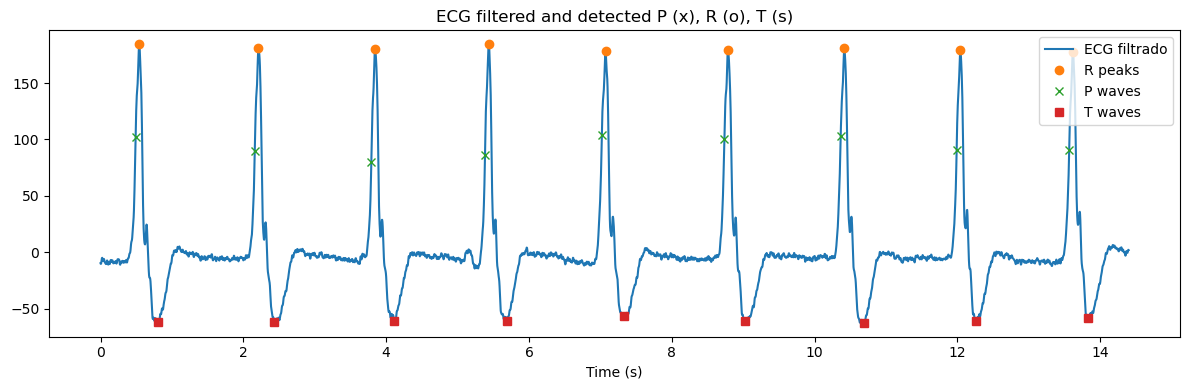

In [ ]:

import os
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt
import pandas as pd

# ---- Config ----
mat_path = "C:/Users/DAVID/Desktop/INTRO A SEÑALES/LAB-EKG-PROCESSING/ECG_DATASET/MLII/11 IVR/207m (1).mat"   # ruta al .mat (ajusta si corresponde)
out_csv = "ecg_207m_detections.csv"
out_png = "ecg_207m_detections.png"

# Filtrado
lowcut = 0.5   # Hz
highcut = 40.0 # Hz
filter_order = 3

# Pan-Tompkins simplificado
integration_win_ms = 150  # ventana de integración en ms
min_rr_ms = 200           # distancia minima entre R en ms

# Ventanas para buscar P y T 
p_win = (-0.300, -0.050)  # 
t_win = (0.120, 0.400)    # 

# -----------------

def bandpass_filter(x, fs, lowcut=0.5, highcut=40.0, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, x)

def load_mat_signal(path):
    mat = sio.loadmat(path)
    signal = None
    sig_name = None
    fs = None
    for k, v in mat.items():
        if isinstance(v, np.ndarray):
            if (v.ndim == 1 or (v.ndim == 2 and 1 in v.shape)) and v.size > 1000 and signal is None:
                signal = v.flatten()
                sig_name = k
        if k.lower() in ['fs','fsample','fsampling','sr','srate']:
            try:
                fs = float(np.squeeze(v))
            except:
                pass
    return signal, sig_name, fs, mat

def main():
    print("Cargando:", mat_path)
    signal, sig_name, fs, mat = load_mat_signal(mat_path)
    if signal is None:
        raise ValueError("No se encontró señal válida en el .mat. Revisa contenido del archivo.")
    print("Señal encontrada en variable:", sig_name)
    if fs is None:
        fs = 250.0
        print("fs no encontrada en .mat; usando fs =", fs, "Hz (ajusta si conoces otro valor).")
    else:
        print("fs detectada:", fs, "Hz")
    ecg = np.asarray(signal, dtype=float)
    ecg = ecg - np.mean(ecg)

    # Filtrado banda
    ecg_f = bandpass_filter(ecg, fs, lowcut=lowcut, highcut=highcut, order=filter_order)

    # Derivación y potenciación
    ecg_diff = np.ediff1d(ecg_f, to_begin=0)
    ecg_sq = ecg_diff ** 2
    win_samples = int(round(integration_win_ms * fs / 1000.0))
    if win_samples < 1:
        win_samples = 1
    ecg_mwi = np.convolve(ecg_sq, np.ones(win_samples)/win_samples, mode='same')

    # Detección de picos R en señal integrada
    peak_min_distance = int(min_rr_ms * fs / 1000.0)
    threshold = np.mean(ecg_mwi)
    peaks, props = find_peaks(ecg_mwi, distance=peak_min_distance, height=threshold)
    print("Número de picos R iniciales:", len(peaks))

    # Refinamiento
    half_win = int(0.05 * fs)
    r_refined = []
    for p in peaks:
        a = max(p-half_win, 0)
        b = min(p+half_win, len(ecg_f)-1)
        local_segment = ecg_f[a:b+1]
        local_max_idx = np.argmax(np.abs(local_segment))
        r_refined.append(a + local_max_idx)
    r_refined = np.array(sorted(set(r_refined)))
    print("Picos R refinados:", len(r_refined))

    # Buscar P y T
    p_locs = []
    p_amps = []
    t_locs = []
    t_amps = []

    for r in r_refined:
        # P
        p_start = int(r + p_win[0] * fs)
        p_end   = int(r + p_win[1] * fs)
        if p_start < 0 or p_end <= p_start:
            p_locs.append(np.nan); p_amps.append(np.nan)
        else:
            seg = ecg_f[p_start:p_end+1]
            if seg.size == 0:
                p_locs.append(np.nan); p_amps.append(np.nan)
            else:
                idx_pos = np.argmax(seg)
                amp_pos = seg[idx_pos]
                idx_neg = np.argmin(seg)
                amp_neg = seg[idx_neg]
                if abs(amp_pos) >= abs(amp_neg):
                    p_locs.append(p_start + idx_pos)
                    p_amps.append(amp_pos)
                else:
                    p_locs.append(p_start + idx_neg)
                    p_amps.append(amp_neg)
        # T
        t_start = int(r + t_win[0] * fs)
        t_end   = int(r + t_win[1] * fs)
        if t_end >= len(ecg_f) or t_end <= t_start:
            t_locs.append(np.nan); t_amps.append(np.nan)
        else:
            seg = ecg_f[t_start:t_end+1]
            if seg.size == 0:
                t_locs.append(np.nan); t_amps.append(np.nan)
            else:
                idx_pos = np.argmax(seg)
                amp_pos = seg[idx_pos]
                idx_neg = np.argmin(seg)
                amp_neg = seg[idx_neg]
                if abs(amp_pos) >= abs(amp_neg):
                    t_locs.append(t_start + idx_pos)
                    t_amps.append(amp_pos)
                else:
                    t_locs.append(t_start + idx_neg)
                    t_amps.append(amp_neg)

    # DataFrame con resultados
    rows = []
    for i, r in enumerate(r_refined):
        rows.append({
            "beat_index": i,
            "r_sample": int(r),
            "r_time_s": r / fs,
            "p_sample": None if np.isnan(p_locs[i]) else int(p_locs[i]),
            "p_time_s": None if np.isnan(p_locs[i]) else float(p_locs[i] / fs),
            "p_amp": None if np.isnan(p_amps[i]) else float(p_amps[i]),
            "t_sample": None if np.isnan(t_locs[i]) else int(t_locs[i]),
            "t_time_s": None if np.isnan(t_locs[i]) else float(t_locs[i] / fs),
            "t_amp": None if np.isnan(t_amps[i]) else float(t_amps[i])
        })
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print("CSV guardado en:", out_csv)

    # Plot general con marcadores
    t_axis = np.arange(len(ecg_f)) / fs
    plt.figure(figsize=(12,4))
    plt.plot(t_axis, ecg_f, label="ECG filtrado")
    plt.plot(r_refined/fs, ecg_f[r_refined], 'o', markersize=6, label="R peaks")
    valid_p = ~np.isnan(p_locs)
    if valid_p.any():
        plt.plot(np.array(p_locs)[valid_p]/fs,
             ecg_f[np.array(p_locs)[valid_p].astype(int)],
             'x', markersize=6, label="P waves")
    valid_t = ~np.isnan(t_locs)
    if valid_t.any():
        plt.plot(np.array(t_locs)[valid_t]/fs,
             ecg_f[np.array(t_locs)[valid_t].astype(int)],
             's', markersize=6, label="T waves")
    plt.xlabel("Time (s)")
    plt.title("ECG filtered and detected P (x), R (o), T (s)")
    plt.legend(loc="upper right")      
    plt.tight_layout()
    plt.savefig(out_png)
    plt.show()

if __name__ == "__main__":
    main()


***Fig 01 - Ploteo de los resultados de EKG con arritmias***

![EKG normal](https://lh6.googleusercontent.com/proxy/JilMnwCJt5yAYwJPLD0OOZVG2ihUTZ1lmbY5sqk19nF0vA6lToB-ZcmX16Qkd5oI9sntbL-0iCh1GjviAI3hAzwqCkVUSAoQkWG9)

***Fig 02 - Ploteo de los resultados de EKG normal***